In [2]:
from dl import queryClient as qc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from functions.dlnpyutils import coords
import functions.parallax as parallax
from astropy.table import Table
import random
from time import perf_counter 
%matplotlib notebook
%matplotlib inline

In [3]:
desdata = Table.read("DES_LT-NSC_DR2-vtan-row_matched.fits", 1)
for i in range(len(desdata)):
    desdata['ID'][i] = desdata['ID'][i].strip()

In [4]:
obj = qc.query(sql='select * from nsc_dr2.hpm where ndet>50 limit 20',fmt='table',profile='db01')
# meas = qc.query(sql="select mjd,ra,dec,mag_auto,raerr,decerr,filter from nsc_dr2.meas where objectid='13694_5947'",fmt='table',profile='db01')
#13694_5947

In [5]:
def parallaxplot(idv):
    plt.ion()
    plt.figure()
    tbl = grabdata(idv)
    pars, cov = parallax.fit(tbl)
    parallax.plotfit(tbl,pars, cov)
    plt.suptitle(idv)
    plt.show()

In [6]:
def grabdata(idv):
    dataselect = "select mjd,ra,dec,mag_auto,raerr,decerr,filter from nsc_dr2.meas where objectid='" + idv + "'"
    meas = qc.query(sql=dataselect,fmt='table',profile='db01')
    return meas

In [9]:
def plots(idv):
    plt.ion()
    try:
        #gather all data used
        dataselect = "select mjd,ra,dec,mag_auto,raerr,decerr,filter from nsc_dr2.meas where objectid='" + idv + "'"
        meas = qc.query(sql=dataselect,fmt='table',profile='db01')
        obj = qc.query(sql="select id,pmra,pmdec from nsc_dr2.hpm where id='"+ idv +"'",fmt='table',profile='db01')
        plt.subplots(2,2, figsize = (9,6))
        plt.subplots_adjust(hspace = .4, wspace = .4)
        plt.suptitle(idv)
        meas["mjd"] -= min(meas["mjd"])
        mjd = (meas["mjd"])
        cenra = np.mean(meas["ra"])
        cendec = np.mean(meas["dec"])
        mag = meas["mag_auto"]
        filters = meas["filter"]
        colors = ["b", "g", "r", "c", "y"]
        ra = meas["ra"]
        dra = ra - cenra
        dra *= 3600 * np.cos(np.deg2rad(cendec))
        dec = meas["dec"]
        ddec = dec - cendec
        ddec *= 3600
        t = meas["mjd"] - np.mean(meas["mjd"])
        pmra = obj["pmra"]/1000/365.2425 # mas/yr -> as/day
        pmdec = obj["pmdec"]/1000/365.2425
        
        #filter some
        goodind = np.where(np.logical_and(abs(ddec) < 500, abs(dra) < 500))             
        ddec = ddec[goodind]
        dra = dra[goodind]
        mjd = mjd[goodind]
        filters = filters[goodind]
        mag = mag[goodind]
        meandra = np.mean(dra)
        meanddec = np.mean(ddec)
        
        #radec code
        plt.subplot(2,2,1)
        plt.scatter(dra, ddec, c = mjd, s = 20)
        diffra = max(dra) - min(dra)
        diffdec = max(ddec) - min(ddec)
        plt.xlim(min(dra) - diffra/4, max(dra) + diffra/4)
        plt.ylim(min(ddec) - diffdec/4, max(ddec) + diffdec/4)
        m, b = np.polyfit(dra, ddec, 1)
        plt.plot(dra, m*dra + b, c = "k")
        plt.colorbar()
        plt.xlabel("dra")
        plt.ylabel("ddec")

        #ratime
        plt.subplot(2,2,2)
        count = 0
        for fil in np.unique(filters):
            filind = np.where(filters == fil)
            plt.scatter(mjd[filind], dra[filind], c = colors[count], label = fil, s = 20)
            count+=1
        plt.legend()
        diffmjd = max(mjd) - min(mjd)
        plt.xlim(min(mjd) - diffmjd/4,  max(mjd) + diffmjd/4)
        plt.ylim(min(dra) - diffra/4, max(dra) + diffra/4)
        m, b = np.polyfit(mjd, dra, 1)        
        plt.plot(mjd, mjd*pmra+b, c = "k")
        plt.xlabel("MJD")
        plt.ylabel("dra")

        #dectime
        plt.subplot(2,2,4)
        count = 0
        for fil in np.unique(filters):
            filind = np.where(filters == fil)
            plt.scatter(mjd[filind], ddec[filind], c = colors[count], label = fil, s = 20)
            count+=1
        plt.legend()
        plt.xlim(min(mjd) - diffmjd/4,  max(mjd) + diffmjd/4)
        plt.ylim(min(ddec) - diffdec/4, max(ddec) + diffdec/4)
        m, b = np.polyfit(mjd, ddec, 1)
        plt.plot(mjd, mjd*pmdec+b, c = "k")
        plt.xlabel("MJD")
        plt.ylabel("ddec")

        #magtime
        plt.subplot(2,2,3)
        count = 0
        for fil in np.unique(filters):
            filind = np.where(filters == fil)
            plt.scatter(mjd[filind], mag[filind], c = colors[count], label = fil, s = 20)
            count+=1
        plt.legend()
        diffmag = max(mag) - min(mag)
        plt.xlim(min(mjd) - diffmjd/4,  max(mjd) + diffmjd/4)
        plt.ylim(min(mag) - diffmag/4, max(mag) + diffmag/4)
        plt.xlabel("MJD")
        plt.ylabel("MAG")

        #parallax
    #     plt.figure()
    #     pars, cov = parallax.fit(meas)
    #     parallax.plotfit(meas,pars, cov)
    except:
        print("This field threw an error ", idv)

In [10]:
def grabids(numberofids = 1):
    n = numberofids
    idlist = []
    for i in range(n):
        idlist.append(desdata["ID"][i])
    return idlist

In [9]:
def randomids(numids = 1):
    ids = []
    for i in range(numids):
        idm = random.choice(desdata["ID"])
        ids.append(idm)
    return ids

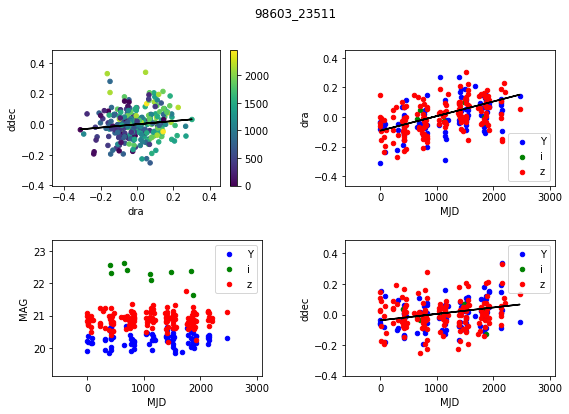

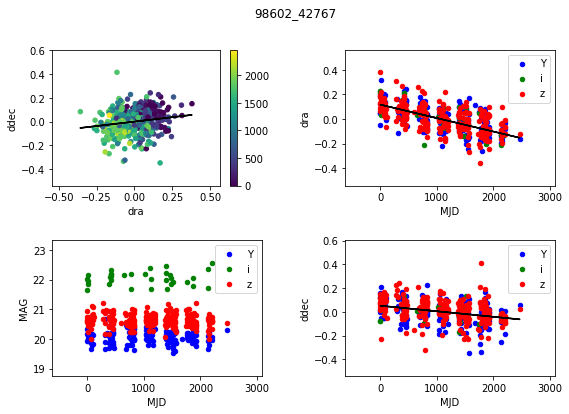

In [13]:
# i = randomids(5)
i = grabids(2)
for idd in i:
    plots(idd)